# Weather Patterns Recognition

## Forecasting MaxTemp of the Next Day using LSTM (Time Series)

In [2]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os
import keras_tuner as kt

In [4]:
df = pd.read_csv("data/weatherAUS.csv")

In [5]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [6]:
# Convert Date column and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [7]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
45587,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,...,68.0,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No,Yes
45588,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,80.0,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,Yes
45589,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,82.0,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,Yes
45590,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,62.0,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,Yes
45591,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,68.0,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,No


In [8]:
city = "Sydney"
df_city = df[df['Location'] == city]

In [9]:
df_city

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
30176,2008-02-01,Sydney,19.5,22.4,15.6,6.2,0.0,NaN,NaN,S,...,92.0,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9,Yes,Yes
30177,2008-02-02,Sydney,19.5,25.6,6.0,3.4,2.7,NaN,NaN,W,...,83.0,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8,Yes,Yes
30178,2008-02-03,Sydney,21.6,24.5,6.6,2.4,0.1,NaN,NaN,ESE,...,88.0,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0,Yes,Yes
30179,2008-02-04,Sydney,20.2,22.8,18.8,2.2,0.0,NaN,NaN,NNE,...,83.0,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9,Yes,Yes
30180,2008-02-05,Sydney,19.7,25.7,77.4,NaN,0.0,NaN,NaN,NNE,...,88.0,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33515,2017-06-21,Sydney,8.6,19.6,0.0,2.0,7.8,SSE,37.0,W,...,73.0,52.0,1025.9,1025.3,2.0,2.0,10.5,17.9,No,No
33516,2017-06-22,Sydney,9.3,19.2,0.0,2.0,9.2,W,30.0,W,...,78.0,53.0,1028.5,1024.6,2.0,2.0,11.0,18.7,No,No
33517,2017-06-23,Sydney,9.4,17.7,0.0,2.4,2.7,W,24.0,WNW,...,85.0,56.0,1020.8,1015.0,6.0,6.0,10.2,17.3,No,No
33518,2017-06-24,Sydney,10.1,19.3,0.0,1.4,9.3,W,43.0,W,...,56.0,35.0,1017.3,1015.1,5.0,2.0,12.4,19.0,No,No


In [10]:
df_city.loc[:, 'MaxTemp'] = df_city['MaxTemp'].ffill()

In [11]:
df_city

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
30176,2008-02-01,Sydney,19.5,22.4,15.6,6.2,0.0,NaN,NaN,S,...,92.0,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9,Yes,Yes
30177,2008-02-02,Sydney,19.5,25.6,6.0,3.4,2.7,NaN,NaN,W,...,83.0,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8,Yes,Yes
30178,2008-02-03,Sydney,21.6,24.5,6.6,2.4,0.1,NaN,NaN,ESE,...,88.0,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0,Yes,Yes
30179,2008-02-04,Sydney,20.2,22.8,18.8,2.2,0.0,NaN,NaN,NNE,...,83.0,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9,Yes,Yes
30180,2008-02-05,Sydney,19.7,25.7,77.4,NaN,0.0,NaN,NaN,NNE,...,88.0,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33515,2017-06-21,Sydney,8.6,19.6,0.0,2.0,7.8,SSE,37.0,W,...,73.0,52.0,1025.9,1025.3,2.0,2.0,10.5,17.9,No,No
33516,2017-06-22,Sydney,9.3,19.2,0.0,2.0,9.2,W,30.0,W,...,78.0,53.0,1028.5,1024.6,2.0,2.0,11.0,18.7,No,No
33517,2017-06-23,Sydney,9.4,17.7,0.0,2.4,2.7,W,24.0,WNW,...,85.0,56.0,1020.8,1015.0,6.0,6.0,10.2,17.3,No,No
33518,2017-06-24,Sydney,10.1,19.3,0.0,1.4,9.3,W,43.0,W,...,56.0,35.0,1017.3,1015.1,5.0,2.0,12.4,19.0,No,No


In [12]:
# Drop if still NaNs
df_city = df_city.dropna(subset=['MaxTemp'])

In [13]:
# Scale MaxTemp
scaler = MinMaxScaler()
df_city['MaxTemp_scaled'] = scaler.fit_transform(df_city[['MaxTemp']])

In [14]:
df_city.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,MaxTemp_scaled
30176,2008-02-01,Sydney,19.5,22.4,15.6,6.2,0.0,NaN,NaN,S,...,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9,Yes,Yes,0.313783
30177,2008-02-02,Sydney,19.5,25.6,6.0,3.4,2.7,NaN,NaN,W,...,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8,Yes,Yes,0.407625
30178,2008-02-03,Sydney,21.6,24.5,6.6,2.4,0.1,NaN,NaN,ESE,...,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0,Yes,Yes,0.375367
30179,2008-02-04,Sydney,20.2,22.8,18.8,2.2,0.0,NaN,NaN,NNE,...,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9,Yes,Yes,0.325513
30180,2008-02-05,Sydney,19.7,25.7,77.4,NaN,0.0,NaN,NaN,NNE,...,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5,Yes,Yes,0.410557


In [15]:
# Create sequences
# Create windows where the X is historical data, and the y is the predicted value
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [16]:
window_size = 30
data = df_city['MaxTemp_scaled'].values
X, y = create_sequences(data, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [17]:
# Split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
# Build model function for tuning
def build_model(hp):
    model = Sequential()
    model.add(
        LSTM(
            units=hp.Int("units", min_value=32, max_value=128, step=32),
            activation=hp.Choice("activation", ["relu", "tanh"]),
            input_shape=(window_size, 1)
        )
    )
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse")
    return model

In [19]:
# Set up Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective="val_loss",
    max_epochs=10,
    factor=3,
    directory="tuner_lstm",
    project_name="forecasting_lstm"
)

In [21]:
# Run hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Trial 8 Complete [00h 00m 04s]
val_loss: 0.009221830405294895

Best val_loss So Far: 0.009153418242931366
Total elapsed time: 00h 00m 28s


In [22]:
# Retrieve and save best model
best_model = tuner.get_best_models(num_models=1)[0]

In [24]:
os.makedirs("models", exist_ok=True)
best_model.save("models/forecasting_lstm_tuned_model.h5")
joblib.dump(scaler, "models/max_temp_scaler_lstm_tuned.pkl")

['models/max_temp_scaler_lstm_tuned.pkl']

### Predict the next day MaxTemp

In [26]:
from tensorflow.keras.models import load_model

# Load model and scaler
model = load_model("models/forecasting_lstm_tuned_model.h5")
# model = load_model("models/forecasting_lstm_model.keras")
scaler = joblib.load("models/max_temp_scaler_lstm_tuned.pkl")

# Use last 30 days from city data
last_30 = df_city['MaxTemp_scaled'].values[-30:]
last_30 = last_30.reshape((1, 30, 1))

# Predict and inverse scale
pred_scaled = model.predict(last_30)[0][0]
pred_temp = scaler.inverse_transform([[pred_scaled]])[0][0]

print(f"Predicted Max Temperature for tomorrow in {city}: {pred_temp:.2f} °C")


1/1 [==============================] - 0s 157ms/step
Predicted Max Temperature for tomorrow in Sydney: 19.83 °C


### Efficiency of the LSTM model

21/21 [==============================] - 0s 2ms/step
Model Performance Metrics:
Root Mean Square Error: 3.26°C
Mean Absolute Error: 2.32°C
R-squared Score: 0.502


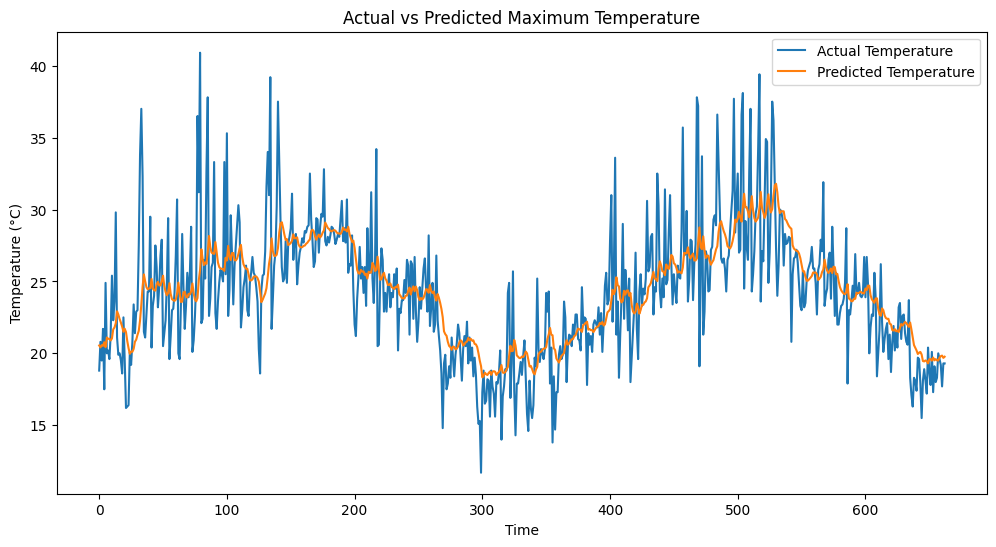

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Make predictions on test data
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate various metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Print evaluation metrics
print(f"Model Performance Metrics:")
print(f"Root Mean Square Error: {rmse:.2f}°C")
print(f"Mean Absolute Error: {mae:.2f}°C")
print(f"R-squared Score: {r2:.3f}")

# Visualize predictions vs actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual Temperature')
plt.plot(y_pred, label='Predicted Temperature')
plt.title('Actual vs Predicted Maximum Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

## Forecasting the MaxTemp of the Next Day using GRU (Time Series)

In [28]:
from tensorflow.keras.layers import GRU

In [29]:
# Build model function
def build_model(hp):
    model = Sequential()
    model.add(
        GRU(
            units=hp.Int("units", min_value=32, max_value=128, step=32),
            activation=hp.Choice("activation", ["relu", "tanh"]),
            input_shape=(window_size, 1)
        )
    )
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse")
    return model

In [30]:
# Hyperparameter tuner
tuner = kt.Hyperband(
    build_model,
    objective="val_loss",
    max_epochs=10,
    factor=3,
    directory="tuner_gru",
    project_name="forecasting_gru"
)

In [32]:

# Run search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Trial 8 Complete [00h 00m 05s]
val_loss: 0.009375637397170067

Best val_loss So Far: 0.008964793756604195
Total elapsed time: 00h 00m 29s


In [33]:
# Best model
best_model = tuner.get_best_models(num_models=1)[0]

In [35]:
# Save tuned model
os.makedirs("models", exist_ok=True)
best_model.save("models/forecasting_gru_tuned_model.h5")
joblib.dump(scaler, "models/max_temp_scaler_gru_tuned.pkl")

['models/max_temp_scaler_gru_tuned.pkl']

### Predicting the Next Day maxTemp

In [36]:
from tensorflow.keras.models import load_model

# Load model and scaler
model = load_model("models/forecasting_gru_tuned_model.h5")
# model = load_model("models/forecasting_lstm_model.keras")
scaler = joblib.load("models/max_temp_scaler_gru_tuned.pkl")

# Use last 30 days from city data
last_30 = df_city['MaxTemp_scaled'].values[-30:]
last_30 = last_30.reshape((1, 30, 1))

# Predict and inverse scale
pred_scaled = model.predict(last_30)[0][0]
pred_temp = scaler.inverse_transform([[pred_scaled]])[0][0]

print(f"Predicted Max Temperature for tomorrow in {city}: {pred_temp:.2f} °C")

1/1 [==============================] - 0s 133ms/step
Predicted Max Temperature for tomorrow in Sydney: 19.24 °C


### Efficiency of the GRU model

21/21 [==============================] - 0s 2ms/step
Model Performance Metrics:
Root Mean Square Error: 3.23°C
Mean Absolute Error: 2.28°C
R-squared Score: 0.512


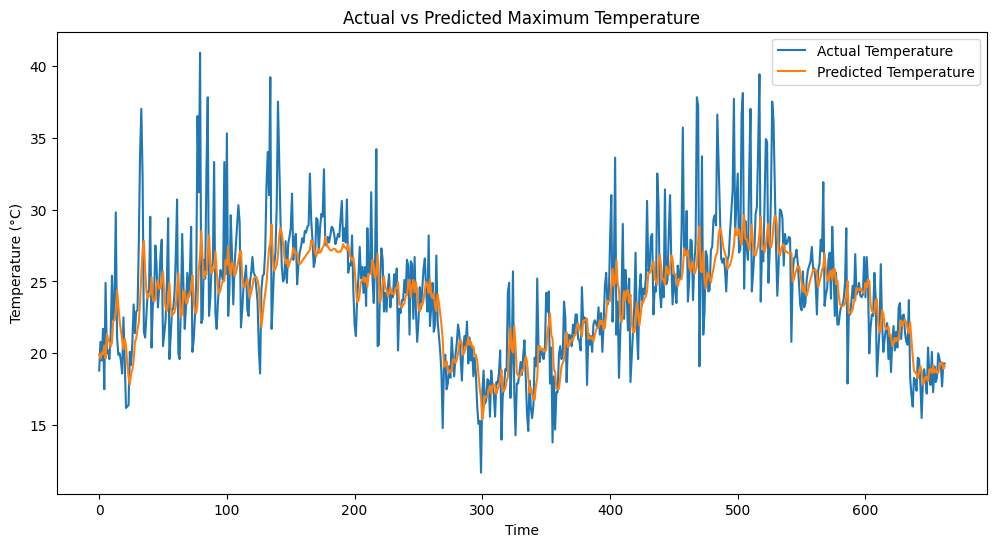

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Make predictions on test data
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate various metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Print evaluation metrics
print(f"Model Performance Metrics:")
print(f"Root Mean Square Error: {rmse:.2f}°C")
print(f"Mean Absolute Error: {mae:.2f}°C")
print(f"R-squared Score: {r2:.3f}")

# Visualize predictions vs actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual Temperature')
plt.plot(y_pred, label='Predicted Temperature')
plt.title('Actual vs Predicted Maximum Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

## Compairing LSTM & GRU models

In [39]:
from tensorflow.keras.models import load_model
import numpy as np
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Load scaler
scaler = joblib.load("models/max_temp_scaler_lstm_tuned.pkl")

# Load models
lstm_model = load_model("models/forecasting_lstm_tuned_model.h5")
gru_model = load_model("models/forecasting_gru_tuned_model.h5")

# Predict
lstm_preds = lstm_model.predict(X_test)
gru_preds = gru_model.predict(X_test)

# Inverse scale
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
lstm_preds_inv = scaler.inverse_transform(lstm_preds)
gru_preds_inv = scaler.inverse_transform(gru_preds)

# Define metric function
def evaluate(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Evaluation:")
    print(f"→ MSE : {mse:.4f}")
    print(f"→ RMSE: {rmse:.4f}")
    print(f"→ MAE : {mae:.4f}")
    print(f"→ R²   : {r2:.4f}")

# Compare
evaluate("LSTM Tuned", y_test_inv, lstm_preds_inv)
evaluate("GRU Tuned", y_test_inv, gru_preds_inv)


21/21 [==============================] - 0s 2ms/step

LSTM Tuned Evaluation:
→ MSE : 10.6437
→ RMSE: 3.2625
→ MAE : 2.3186
→ R²   : 0.5022

GRU Tuned Evaluation:
→ MSE : 10.4244
→ RMSE: 3.2287
→ MAE : 2.2776
→ R²   : 0.5125


## Predicting whehter it will rain tomorrow or not

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [41]:
# Load data
df = pd.read_csv("data/weatherAUS.csv")

# Drop rows with missing target
df = df.dropna(subset=["RainTomorrow"])

In [42]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,...,59.0,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,No
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No


In [43]:
# Encode target variable
df["RainTomorrow"] = LabelEncoder().fit_transform(df["RainTomorrow"])  # Yes = 1, No = 0

In [44]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,...,59.0,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,0
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,0
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,0
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,0


In [45]:
# Select features
features = ["MinTemp", "MaxTemp", "Rainfall", "Humidity3pm", "Pressure9am", "WindGustSpeed"]
df = df.dropna(subset=features)

X = df[features]
y = df["RainTomorrow"]

In [46]:
X

,MinTemp,MaxTemp,Rainfall,Humidity3pm,Pressure9am,WindGustSpeed
0,13.4,22.9,0.6,22.0,1007.7,44.0
1,7.4,25.1,0.0,25.0,1010.6,44.0
2,12.9,25.7,0.0,30.0,1007.6,46.0
3,9.2,28.0,0.0,16.0,1017.6,24.0
4,17.5,32.3,1.0,33.0,1010.8,41.0
...,...,...,...,...,...,...
145454,3.5,21.8,0.0,27.0,1024.7,31.0
145455,2.8,23.4,0.0,24.0,1024.6,31.0
145456,3.6,25.3,0.0,21.0,1023.5,22.0
145457,5.4,26.9,0.0,24.0,1021.0,37.0


In [47]:
y

0         0
1         0
2         0
3         0
4         0
         ..
145454    0
145455    0
145456    0
145457    0
145458    0
Name: RainTomorrow, Length: 119941, dtype: int64

In [48]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [49]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [50]:
# Train the model
# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [51]:
# Evaluate
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8474717578890325
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     18831
           1       0.71      0.49      0.58      5158

    accuracy                           0.85     23989
   macro avg       0.79      0.72      0.74     23989
weighted avg       0.84      0.85      0.84     23989



In [52]:
# Save model and scaler
joblib.dump(clf, "models/classifier_rain_tomorrow.pkl")
joblib.dump(scaler, "models/classifier_scaler.pkl")

['models/classifier_scaler.pkl']

## Clustering – Group Cities by Weather Patterns


In [53]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [54]:
# Load data
df = pd.read_csv("data/weatherAUS.csv")

# Group by Location and take mean of selected features
features = ["MinTemp", "MaxTemp", "Rainfall", "Humidity9am", "Humidity3pm", "Pressure9am"]
df_grouped = df.groupby("Location")[features].mean().dropna()

In [55]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [56]:
df_grouped

,MinTemp,MaxTemp,Rainfall,Humidity9am,Humidity3pm,Pressure9am
Location,,,,,,
Adelaide,12.579505,22.898934,1.566354,59.701066,44.828105,1018.764082
Albany,12.948438,20.070998,2.263859,74.805416,67.407917,1018.275721
Albury,9.530604,22.640872,1.914115,74.070604,47.869393,1018.369621
AliceSprings,13.142284,29.248420,0.882850,39.690155,24.131466,1016.684732
BadgerysCreek,11.131719,24.031208,2.193101,76.895770,51.381855,1018.461598
Ballarat,7.367950,18.287266,1.740026,81.817820,59.030992,1017.845093
Bendigo,8.593713,21.621746,1.619380,70.545664,46.474325,1018.026281
Brisbane,16.423807,26.448380,3.144891,64.043587,53.912209,1018.232989
Cairns,21.220467,29.558849,5.742035,69.936821,61.751645,1014.151333


In [57]:
# Scale
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_grouped)

In [58]:
# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
df_grouped["Cluster"] = kmeans.fit_predict(scaled_data)


In [59]:
df_grouped

,MinTemp,MaxTemp,Rainfall,Humidity9am,Humidity3pm,Pressure9am,Cluster
Location,,,,,,,
Adelaide,12.579505,22.898934,1.566354,59.701066,44.828105,1018.764082,3
Albany,12.948438,20.070998,2.263859,74.805416,67.407917,1018.275721,1
Albury,9.530604,22.640872,1.914115,74.070604,47.869393,1018.369621,1
AliceSprings,13.142284,29.248420,0.882850,39.690155,24.131466,1016.684732,2
BadgerysCreek,11.131719,24.031208,2.193101,76.895770,51.381855,1018.461598,1
Ballarat,7.367950,18.287266,1.740026,81.817820,59.030992,1017.845093,1
Bendigo,8.593713,21.621746,1.619380,70.545664,46.474325,1018.026281,1
Brisbane,16.423807,26.448380,3.144891,64.043587,53.912209,1018.232989,3
Cairns,21.220467,29.558849,5.742035,69.936821,61.751645,1014.151333,0


In [60]:
# Save clustering model
joblib.dump(kmeans, "models/kmeans_weather.pkl")
joblib.dump(scaler, "models/cluster_scaler.pkl")

['models/cluster_scaler.pkl']

In [61]:
df_grouped.reset_index().to_csv("data/clustered_locations.csv", index=False)

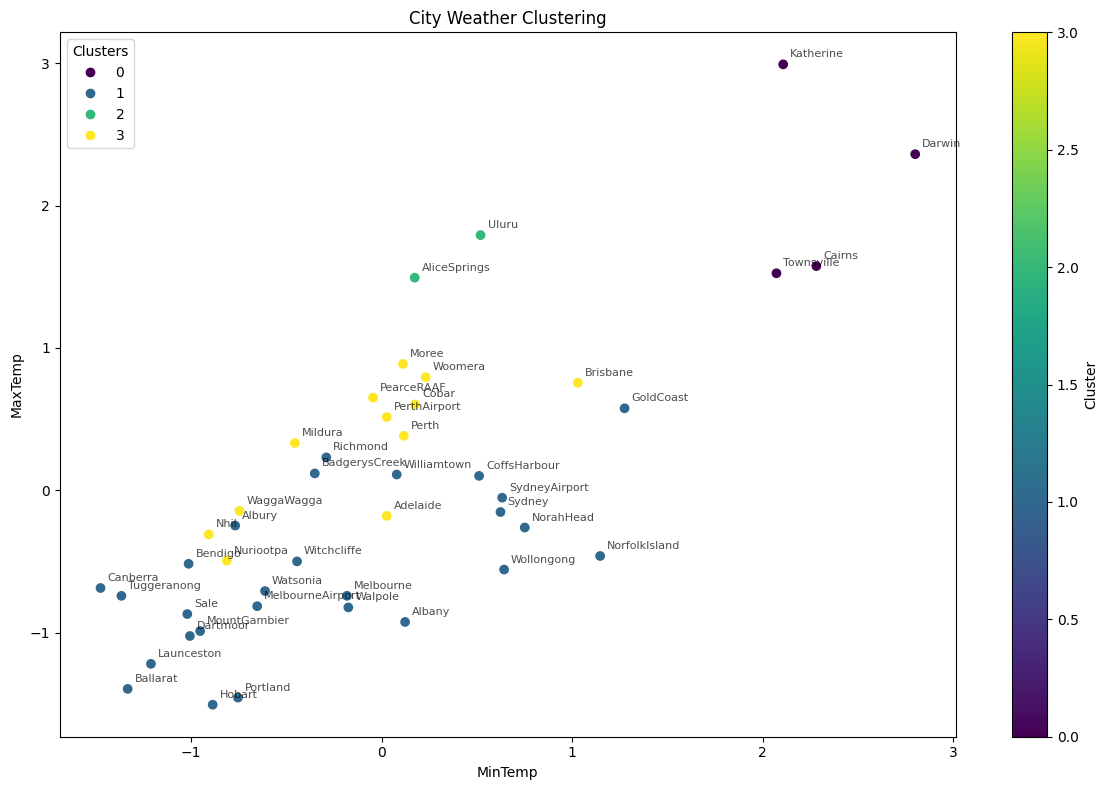

In [62]:
# Visualize with legends
plt.figure(figsize=(12, 8))  # Made figure larger to accommodate labels

# Create scatter plot
scatter = plt.scatter(scaled_data[:, 0], scaled_data[:, 1], 
                     c=df_grouped["Cluster"], 
                     cmap="viridis")

# Add city names as annotations
for idx, city in enumerate(df_grouped.index):
    plt.annotate(city,  # The text to add
                (scaled_data[idx, 0], scaled_data[idx, 1]),  # Point to label
                xytext=(5, 5),  # Text offset from point
                textcoords='offset points',  # How to interpret offset
                fontsize=8,  # Smaller font size for clarity
                alpha=0.7)  # Slight transparency for better readability

plt.xlabel("MinTemp")
plt.ylabel("MaxTemp")
plt.title("City Weather Clustering")

# Add legend
legend = plt.legend(*scatter.legend_elements(),
                   title="Clusters",
                   loc="best")
plt.colorbar(scatter, label="Cluster")

# Adjust layout to prevent label overlap
plt.tight_layout()
plt.show()

In [ ]:
""" Interpretation:
Cluster 0: Might be tropical cities (hot, humid)
Cluster 1: Might be temperate cities
Cluster 2: Might be coastal cities
Cluster 3: Might be cooler cities
This clustering helps identify cities with similar weather patterns, which can be useful for:
Climate zone identification
Weather pattern analysis
Regional weather forecasting
Climate change studies """